# Image model training
INPUTS: First image showing the object unhindered by the robot grasper. <br>
OUTPUTS: The predicted item, one-hot encoding. 

In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
WIDTH=80
IMG_SIZE=WIDTH
HEIGHT=80
EPOCHS=20
LR=1e-3
MODEL_NAME='FYP17_item_classifier-{}{}.model'.format(LR,'_V7')
directory='./model_image_prediction/'
train_data=np.load('training_data_all_360.npy')
number_items=len(train_data[0][5])
print('done')

done


## Defining the Model
A simple 4 layer CNN with 2 FCL is used for model training/prediction. 
The amount of data isn't complex so we won't need a complex model.

In [2]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.layers.normalization import batch_normalization

import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input') 

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = batch_normalization (convnet)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = batch_normalization (convnet)
convnet = dropout(convnet, 0.7)

convnet = conv_2d(convnet, 256, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = batch_normalization (convnet)

convnet = conv_2d(convnet, 256, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = batch_normalization (convnet)
convnet = dropout(convnet, 0.7)

convnet = fully_connected(convnet, 512, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, number_items, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='C:\Tensorboard_logs\FYP17_image_myway\log')

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


## Begin Training!
We use TFlearn because it's easily implementable and requires little effort. The model fits over a set number of epochs and the model is saved every EPOCH

In [8]:
directory='./model_image_prediction/'
for i in range(EPOCHS):
    train_data = np.load('training_data_all_360.npy')

    train = train_data[:-int(len(train_data)*0.15)]
    test = train_data[-int(len(train_data)*0.15):]

    X = np.array([i[0] for i in train]).reshape(-1,WIDTH,HEIGHT,1)
    Y = [i[5] for i in train]

    test_x = np.array([i[0] for i in test]).reshape(-1,WIDTH,HEIGHT,1)
    test_y = [i[5] for i in test]

    model.fit({'input': X}, {'targets': Y}, n_epoch=1, validation_set=({'input': test_x}, {'targets': test_y}), 
        snapshot_step=10000, show_metric=True, run_id=MODEL_NAME)

    #tensorboard --logdir=foo:C:/Tensorboard_logs/FYP17/log

    model.save(directory+MODEL_NAME)

Training Step: 1064  | total loss: 0.01193 | time: 6.182s
| Adam | epoch: 008 | loss: 0.01193 - acc: 0.9979 -- iter: 9344/9367
Training Step: 1065  | total loss: 0.01078 | time: 7.241s
| Adam | epoch: 008 | loss: 0.01078 - acc: 0.9981 | val_loss: 0.81327 - val_acc: 0.9008 -- iter: 9367/9367
--
INFO:tensorflow:C:\Users\William Jiang\Documents\FYP17_tensorflow_demo\model_image_prediction\FYP17_item_classifier-0.001_V7.model is not in all_model_checkpoint_paths. Manually adding it.


KeyboardInterrupt: 

In [4]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

## Visualizing our results.
We've created a little 12 plot with actual and predicted angles. 

## Training data visualization

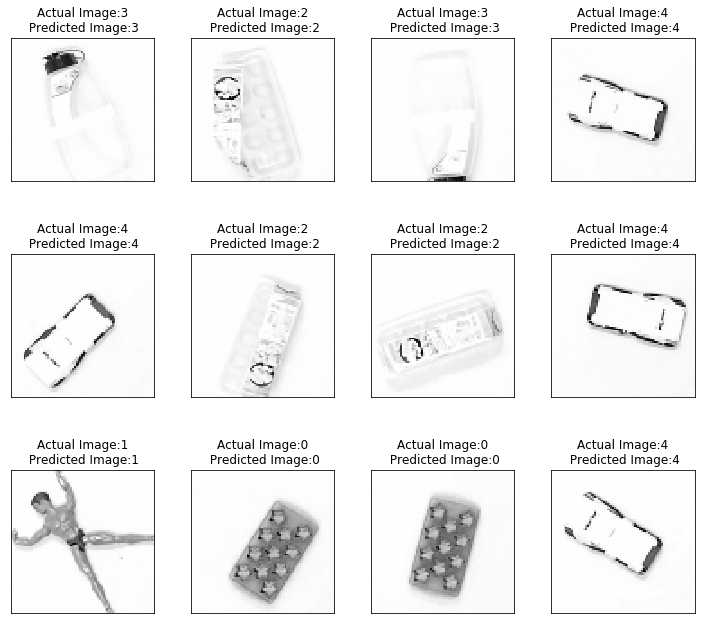

In [5]:
import matplotlib.pyplot as plt
import random
IMG_SIZE=WIDTH
random_int=random.randint(0, len(train_data)-12)
# if you already have some saved:
train_data = np.load('training_data_all_360.npy')

fig=plt.figure(figsize=(10,10))

for num,data in enumerate(train_data[random_int:random_int+12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[5]
    img_data = data[0]
    y = fig.add_subplot(3,4,num+1)
    fig.tight_layout()
    #plt.subplots_adjust(wspace=1,hspace=0.5)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    str_label=np.argmax(model_out)
    actual_angle=np.argmax(img_num)
    title='Actual Image:{}\n Predicted Image:{}'.format(actual_angle,str_label)
    
    y.imshow(orig,cmap='gray')
    plt.title(title)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

## Testing data visualization

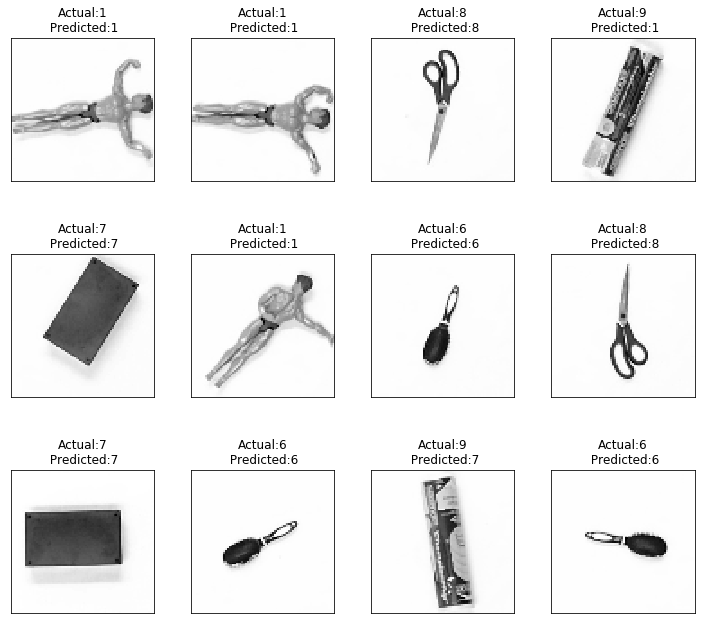

In [6]:
fig=plt.figure(figsize=(10,10))
random_int=random.randint(0, len(test)-12)
for num,data in enumerate(test[random_int:random_int+12]):    
    img_num = data[5]
    img_data = data[0]
    y = fig.add_subplot(3,4,num+1)
    fig.tight_layout()
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    str_label=np.argmax(model_out)
    actual_angle=np.argmax(img_num)
    title='Actual:{}\n Predicted:{}'.format(actual_angle,str_label)
    
    y.imshow(orig,cmap='gray')
    plt.title(title)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()


## Testing for Accuracy
Simply just number of correct answers divided by the total count of test images

In [7]:
accuracy_sum=0
n=0
for num,data in enumerate(test):
    n=n+1
    img_num = data[5]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    if np.argmax(model_out)==np.argmax(img_num):
        accuracy_sum=accuracy_sum+ 1
accuracy=accuracy_sum/n
accuracy

0.9007864488808227